# Delta Hedging Simulation

# Parameters

In [1]:
S0 = 100.0
K = 100.0
days_to_expiry = 30
implied_vol = 0.2          
realized_vol = 0.25       
r = 0.0
mu = 0.0
option_type = "call"
option_position = "long"
dt = 1.0/252.0
random_seed = None

# Volatility model controls
vol_model = "ou"           # "constant" or "ou"
use_vol_for_price = True   
rho_sv = -0.4              # correlation between stock and vol shocks

# OU parameters for implied vol dynamics dσ = κ(θ-σ)dt + ξ dW
ou_kappa = 3.0
ou_theta = implied_vol
ou_xi = 1.0
vol_floor = 0.05          
vol_cap = 1.00             

In [2]:
import numpy as np
import pandas as pd
from math import log, sqrt, exp, erf, pi
import matplotlib.pyplot as plt
from IPython.display import display
from typing import Optional, Tuple

def norm_cdf(x: float) -> float:
    return 0.5 * (1.0 + erf(x / sqrt(2.0)))

def norm_pdf(x: float) -> float:
    return exp(-0.5 * x * x) / sqrt(2.0 * pi)

def _safe_vsigma_T(sigma: float, T: float, eps: float = 1e-12) -> float:
    return max(eps, sigma * sqrt(max(0.0, T)))

def _d1d2(S: float, K: float, T: float, r: float, sigma: float) -> Tuple[float, float]:
    vT = _safe_vsigma_T(sigma, T)
    d1 = (log(S / K) + (r + 0.5 * sigma * sigma) * T) / vT
    d2 = d1 - vT
    return d1, d2

def bs_price(S: float, K: float, T: float, r: float, sigma: float, typ: str) -> float:
    if T <= 0.0:
        return max(S - K, 0.0) if typ == "call" else max(K - S, 0.0)
    if S <= 0.0 or K <= 0.0:
        raise ValueError("S and K must be positive")
    d1, d2 = _d1d2(S, K, T, r, sigma)
    if typ == "call":
        return S * norm_cdf(d1) - K * exp(-r * T) * norm_cdf(d2)
    if typ == "put":
        return K * exp(-r * T) * norm_cdf(-d2) - S * norm_cdf(-d1)
    raise ValueError("typ must be 'call' or 'put'")

def bs_delta(S: float, K: float, T: float, r: float, sigma: float, typ: str) -> float:
    if T <= 0.0:
        if typ == "call":
            return 1.0 if S > K else 0.0
        if typ == "put":
            return -1.0 if S < K else 0.0
        raise ValueError("typ must be 'call' or 'put'")
    d1, _ = _d1d2(S, K, T, r, sigma)
    if typ == "call":
        return norm_cdf(d1)
    if typ == "put":
        return norm_cdf(d1) - 1.0
    raise ValueError("typ must be 'call' or 'put'")

def bs_gamma(S: float, K: float, T: float, r: float, sigma: float) -> float:
    if T <= 0.0 or S <= 0.0:
        return 0.0
    d1, _ = _d1d2(S, K, T, r, sigma)
    return norm_pdf(d1) / (S * _safe_vsigma_T(sigma, T))

def bs_vega(S: float, K: float, T: float, r: float, sigma: float) -> float:
    if T <= 0.0:
        return 0.0
    d1, _ = _d1d2(S, K, T, r, sigma)
    return S * norm_pdf(d1) * sqrt(T)  

def bs_theta(S: float, K: float, T: float, r: float, sigma: float, typ: str) -> float:
    if T <= 0.0:
        return 0.0
    d1, d2 = _d1d2(S, K, T, r, sigma)
    term1 = - (S * norm_pdf(d1) * sigma) / (2.0 * sqrt(T))
    if typ == "call":
        term2 = - r * K * exp(-r * T) * norm_cdf(d2)
        return term1 + term2 
    if typ == "put":
        term2 = + r * K * exp(-r * T) * norm_cdf(-d2)
        return term1 + term2
    raise ValueError("typ must be 'call' or 'put'")

def bs_rho(S: float, K: float, T: float, r: float, sigma: float, typ: str) -> float:
    if T <= 0.0:
        return 0.0
    _, d2 = _d1d2(S, K, T, r, sigma)
    if typ == "call":
        return K * T * exp(-r * T) * norm_cdf(d2)
    if typ == "put":
        return -K * T * exp(-r * T) * norm_cdf(-d2)
    raise ValueError("typ must be 'call' or 'put'")

def bs_vanna(S: float, K: float, T: float, r: float, sigma: float) -> float:
    if T <= 0.0 or sigma <= 0.0:
        return 0.0
    d1, d2 = _d1d2(S, K, T, r, sigma)
    return -norm_pdf(d1) * d2 / max(sigma, 1e-12)

def bs_volga(S: float, K: float, T: float, r: float, sigma: float) -> float:
    if T <= 0.0 or sigma <= 0.0:
        return 0.0
    d1, d2 = _d1d2(S, K, T, r, sigma)
    return bs_vega(S, K, T, r, sigma) * d1 * d2 / max(sigma, 1e-12)

def gbm_step_with_z(S: float, mu: float, sigma: float, dt: float, z: float) -> float:
    if S <= 0.0:
        raise ValueError("S must be positive")
    return S * exp((mu - 0.5 * sigma * sigma) * dt + sigma * sqrt(dt) * z)

def vol_step(sigma_prev: float, dt: float, z_vol: float) -> float:
    if vol_model == "constant":
        return sigma_prev
    if vol_model == "ou":
        sigma_next = sigma_prev + ou_kappa * (ou_theta - sigma_prev) * dt + ou_xi * sqrt(dt) * z_vol
        sigma_next = max(vol_floor, min(vol_cap, sigma_next))
        return sigma_next
    raise ValueError("Unsupported vol_model")

def simulate_delta_hedge(
    S0, K, days, iv0, rv_const, r, mu,
    option_type, option_position, dt, random_seed=None,
    trade_eps=1e-10, flatten_at_expiry=True
):
    if random_seed is not None:
        np.random.seed(random_seed)

    pos_sign = 1.0 if option_position == "long" else -1.0
    rows = []
    buy_markers, sell_markers = [], []
    running_total_pl = 0.0
    total_option_pl = 0.0
    total_stock_pl = 0.0
    total_shares_bought = 0.0
    total_buy_cost = 0.0
    total_shares_sold = 0.0
    total_sell_revenue = 0.0
    log_rets = []

    S = S0
    sigma_iv = iv0
    T0 = days * dt

    opt_price = bs_price(S, K, T0, r, sigma_iv, option_type)
    opt_delta = bs_delta(S, K, T0, r, sigma_iv, option_type)
    opt_gamma = bs_gamma(S, K, T0, r, sigma_iv)
    opt_theta = bs_theta(S, K, T0, r, sigma_iv, option_type)
    opt_vega = bs_vega(S, K, T0, r, sigma_iv)
    opt_rho = bs_rho(S, K, T0, r, sigma_iv, option_type)
    opt_vanna = bs_vanna(S, K, T0, r, sigma_iv)
    opt_volga = bs_volga(S, K, T0, r, sigma_iv)

    shares = -opt_delta if option_position == "long" else opt_delta

    if shares > 0:
        buy_markers.append((0, S, shares))
        total_shares_bought += shares
        total_buy_cost += shares * S
    elif shares < 0:
        sell_markers.append((0, S, shares))
        total_shares_sold += -shares
        total_sell_revenue += (-shares) * S

    rows.append(dict(
        day=0, S=S, option_price=opt_price, sigma_iv=sigma_iv,
        delta=opt_delta, gamma=opt_gamma, theta=opt_theta, vega=opt_vega, rho=opt_rho,
        vanna=opt_vanna, volga=opt_volga,
        shares_held=shares,
        daily_stock_pl=0.0, daily_option_pl=0.0, total_daily_pl=0.0, running_pl=0.0,
        gamma_pnl=0.0, theta_pnl=0.0, vega_pnl=0.0, rho_pnl=0.0,
        vanna_pnl=0.0, volga_pnl=0.0,
        approx_greek_pnl=0.0, residual_pl=0.0, explained_pct=np.nan
    ))

    for d in range(1, days + 1):
        z1 = np.random.normal()
        z2 = np.random.normal()
        z_s = z1
        z_v = rho_sv * z1 + sqrt(max(0.0, 1.0 - rho_sv**2)) * z2

        S_prev, opt_prev, shares_prev = S, opt_price, shares
        T_prev = max(T0 - (d - 1) * dt, 0.0)
        sigma_prev = sigma_iv

        gamma_prev = bs_gamma(S_prev, K, T_prev, r, sigma_prev)
        theta_prev = bs_theta(S_prev, K, T_prev, r, sigma_prev, option_type)
        vega_prev  = bs_vega (S_prev, K, T_prev, r, sigma_prev)
        rho_prev   = bs_rho  (S_prev, K, T_prev, r, sigma_prev, option_type)
        vanna_prev = bs_vanna(S_prev, K, T_prev, r, sigma_prev)
        volga_prev = bs_volga(S_prev, K, T_prev, r, sigma_prev)

        sigma_for_price = sigma_prev if use_vol_for_price else rv_const
        S = gbm_step_with_z(S_prev, mu=mu, sigma=sigma_for_price, dt=dt, z=z_s)
        if S_prev > 0.0 and S > 0.0:
            log_rets.append(np.log(S / S_prev))

        sigma_iv = vol_step(sigma_prev, dt, z_v)
        T = max(T0 - d * dt, 0.0)

        opt_price = bs_price(S, K, T, r, sigma_iv, option_type)
        opt_delta = bs_delta(S, K, T, r, sigma_iv, option_type)
        opt_gamma = bs_gamma(S, K, T, r, sigma_iv)
        opt_theta = bs_theta(S, K, T, r, sigma_iv, option_type)
        opt_vega  = bs_vega (S, K, T, r, sigma_iv)
        opt_rho   = bs_rho  (S, K, T, r, sigma_iv, option_type)
        opt_vanna = bs_vanna(S, K, T, r, sigma_iv)
        opt_volga = bs_volga(S, K, T, r, sigma_iv)

        target_shares = 0.0 if (flatten_at_expiry and T == 0.0) else (-opt_delta if option_position == "long" else opt_delta)
        trade = target_shares - shares_prev
        if trade > trade_eps:
            buy_markers.append((d, S, trade))
            total_shares_bought += trade
            total_buy_cost += trade * S
        elif trade < -trade_eps:
            sell_markers.append((d, S, trade))
            total_shares_sold += -trade
            total_sell_revenue += (-trade) * S
        shares = target_shares

        dS = S - S_prev
        d_sigma = sigma_iv - sigma_prev
        d_r = 0.0  

        daily_stock_pl = dS * shares_prev
        daily_option_pl = (opt_price - opt_prev) if option_position == "long" else (opt_prev - opt_price)
        total_daily_pl = daily_stock_pl + daily_option_pl

        theta_pnl = pos_sign * theta_prev * dt
        gamma_pnl = pos_sign * 0.5 * gamma_prev * (dS ** 2)
        vega_pnl  = pos_sign * vega_prev  * d_sigma
        rho_pnl   = pos_sign * rho_prev   * d_r
        vanna_pnl = pos_sign * vanna_prev * dS * d_sigma
        volga_pnl = pos_sign * 0.5 * volga_prev * (d_sigma ** 2)

        approx = theta_pnl + gamma_pnl + vega_pnl + rho_pnl + vanna_pnl + volga_pnl
        residual = total_daily_pl - approx
        explained_pct = np.nan if abs(total_daily_pl) < 1e-14 else (approx / total_daily_pl)

        running_total_pl += total_daily_pl
        total_option_pl += daily_option_pl
        total_stock_pl += daily_stock_pl

        rows.append(dict(
            day=d, S=S, option_price=opt_price, sigma_iv=sigma_iv,
            delta=opt_delta, gamma=opt_gamma, theta=opt_theta, vega=opt_vega, rho=opt_rho,
            vanna=opt_vanna, volga=opt_volga,
            shares_held=shares,
            daily_stock_pl=daily_stock_pl, daily_option_pl=daily_option_pl,
            total_daily_pl=total_daily_pl, running_pl=running_total_pl,
            gamma_pnl=gamma_pnl, theta_pnl=theta_pnl, vega_pnl=vega_pnl, rho_pnl=rho_pnl,
            vanna_pnl=vanna_pnl, volga_pnl=volga_pnl,
            approx_greek_pnl=approx, residual_pl=residual, explained_pct=explained_pct
        ))

    df = pd.DataFrame(rows)
    df["cum_approx_greek_pnl"] = df["approx_greek_pnl"].cumsum()
    df["cum_total_daily_pl"] = df["total_daily_pl"].cumsum()
    df["explained_pct_cum"] = np.where(
        abs(df["cum_total_daily_pl"]) < 1e-14, np.nan, df["cum_approx_greek_pnl"] / df["cum_total_daily_pl"]
    )

    realized_vol_annual = float(np.std(log_rets, ddof=1) * sqrt(1.0 / dt)) if len(log_rets) > 1 and dt > 0.0 else 0.0
    avg_buy = (total_buy_cost / total_shares_bought) if total_shares_bought > 0 else 0.0
    avg_sell = (total_sell_revenue / total_shares_sold) if total_shares_sold > 0 else 0.0

    summary = dict(
        final_total_pl=running_total_pl,
        total_option_pl=total_option_pl,
        total_stock_pl=total_stock_pl,
        realized_vol_annual=realized_vol_annual,
        total_shares_bought=total_shares_bought, avg_buy_price=avg_buy,
        total_shares_sold=total_shares_sold, avg_sell_price=avg_sell,
        theta_pnl_sum=df["theta_pnl"].sum(),
        gamma_pnl_sum=df["gamma_pnl"].sum(),
        vega_pnl_sum=df["vega_pnl"].sum(),
        vanna_pnl_sum=df["vanna_pnl"].sum(),
        volga_pnl_sum=df["volga_pnl"].sum(),
    )

    markers_df = pd.DataFrame(
        buy_markers + sell_markers, columns=["day", "price", "qty"]
    ).assign(kind=lambda x: np.where(x["qty"] >= 0, "buy", "sell"))

    return df, summary, markers_df

# Run simulation, table and plots

,day,S,option_price,sigma_iv,delta,gamma,theta,vega,daily_stock_pl,daily_option_pl,total_daily_pl,gamma_pnl,theta_pnl,vega_pnl,approx_greek_pnl,residual_pl,explained_pct,explained_pct_cum
0,0,100.0000,2.7524,0.2000,0.5138,0.0578,-11.5556,13.7566,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,NaN
1,1,99.9129,2.6457,0.1988,0.5083,0.0592,-11.6778,13.5187,0.0447,-0.1067,-0.0620,0.0002,-0.0459,-0.0163,-0.0619,-0.0001,0.9985,0.9985
2,2,100.3891,3.5941,0.2550,0.5351,0.0466,-15.2569,13.2980,-0.2421,0.9484,0.7064,0.0067,-0.0463,0.7589,0.7217,-0.0153,1.0217,1.0239
3,3,102.2207,4.5138,0.2489,0.6219,0.0457,-14.7728,12.7207,-0.9802,0.9197,-0.0605,0.0781,-0.0605,-0.0812,-0.0635,0.0031,1.0504,1.0212
4,4,101.0814,3.5593,0.2319,0.5721,0.0521,-14.3211,12.7410,0.7085,-0.9545,-0.2460,0.0296,-0.0586,-0.2152,-0.2504,0.0044,1.0177,1.0237
5,5,102.1604,5.6105,0.3503,0.5983,0.0343,-21.9735,12.4455,-0.6173,2.0512,1.4339,0.0303,-0.0568,1.5082,1.4661,-0.0322,1.0224,1.0227
6,6,103.1196,7.3820,0.4552,0.6137,0.0264,-29.1002,12.1767,-0.5738,1.7716,1.1977,0.0158,-0.0872,1.3054,1.2253,-0.0276,1.0231,1.0228
7,7,99.3691,6.0665,0.5314,0.5163,0.0250,-34.8327,11.9664,2.3016,-1.3155,0.9861,0.1858,-0.1155,0.9272,1.0365,-0.0504,1.0511,1.0299
8,8,105.9892,9.3625,0.4857,0.6833,0.0234,-31.0142,11.1496,-3.4179,3.2960,-0.1219,0.5476,-0.1382,-0.5465,-0.1644,0.0424,1.3480,1.0198
9,9,108.8588,11.3027,0.4858,0.7503,0.0208,-29.0914,9.9802,-1.9609,1.9402,-0.0207,0.0964,-0.1231,0.0015,-0.0253,0.0046,1.2214,1.0187



Summary:
final_total_pl: $2.68
total_option_pl: 3.783827
total_stock_pl: -1.102888
realized_vol_annual: 38.93%
total_shares_bought: 1.623663
avg_buy_price: 104.747321
total_shares_sold: 1.623663
avg_sell_price: 104.068062
theta_pnl_sum: $-2.74
gamma_pnl_sum: $2.92
vega_pnl_sum: $2.15
vanna_pnl_sum: $-0.13
volga_pnl_sum: $0.25


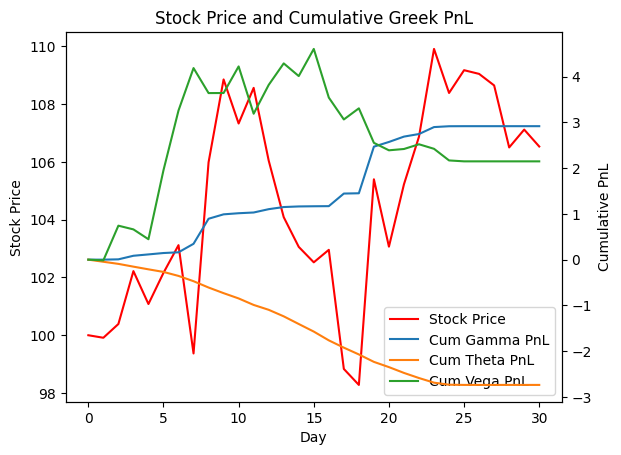

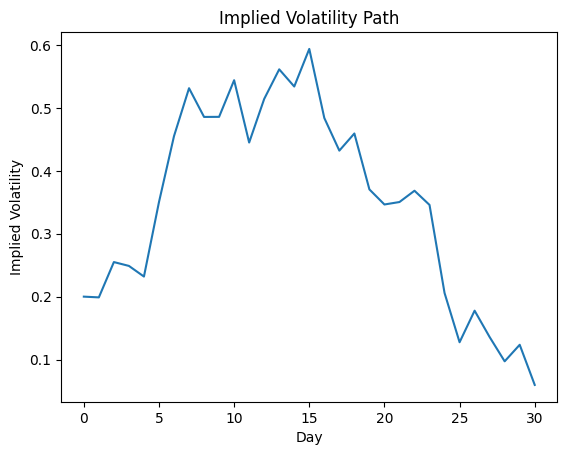

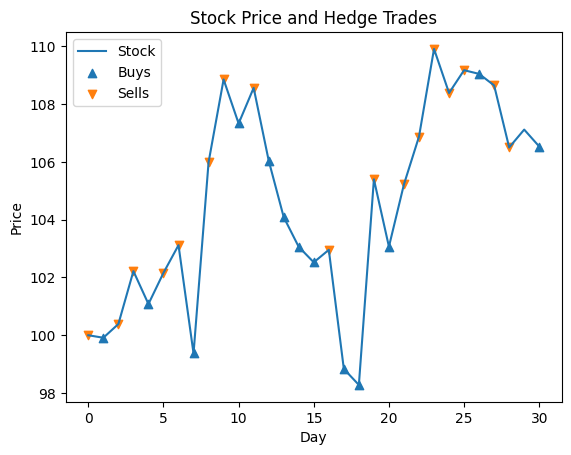

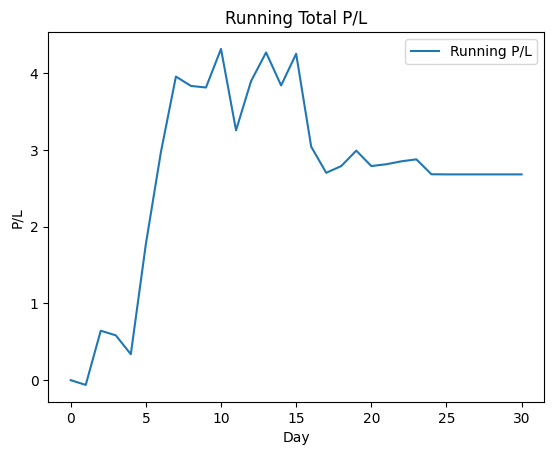

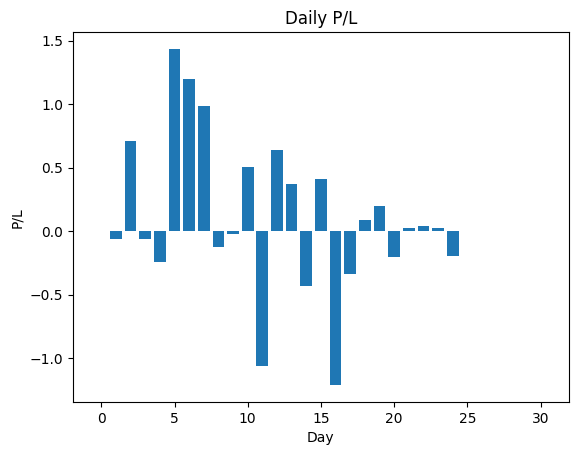

In [ ]:
df, summary, markers = simulate_delta_hedge(
    S0, K, days_to_expiry, implied_vol, realized_vol, r, mu,
    option_type, option_position, dt, random_seed
)

# Ignoring vanna and volga for display
cols_show = [
    "day","S","option_price","sigma_iv",
    "delta","gamma","theta","vega",
    "daily_stock_pl","daily_option_pl","total_daily_pl",
    "gamma_pnl","theta_pnl","vega_pnl","approx_greek_pnl","residual_pl",
    "explained_pct","explained_pct_cum"
]
pd.set_option('display.precision', 4)
pd.set_option('display.float_format', '{:,.4f}'.format)
display(df[cols_show])  

print("\nSummary:")
for k, v in summary.items():
    if "pnl" in k or "final" in k:
        try:
            print(f"{k}: ${v:,.2f}")
        except Exception:
            print(f"{k}: {v}")
    elif "vol" in k:
        print(f"{k}: {100*v:.2f}%")
    elif "explained_pct" in k:
        print(f"{k}: {100*v:.2f}%")
    else:
        print(f"{k}: {v:,.6f}")

fig, ax1 = plt.subplots()
ax1.plot(df["day"], df["S"], label="Stock Price", color="red")
ax1.set_xlabel("Day")
ax1.set_ylabel("Stock Price")
ax2 = ax1.twinx()
ax2.plot(df["day"], df["gamma_pnl"].cumsum(), label="Cum Gamma PnL")
ax2.plot(df["day"], df["theta_pnl"].cumsum(), label="Cum Theta PnL")
ax2.plot(df["day"], df["vega_pnl"].cumsum(), label="Cum Vega PnL")
ax2.set_ylabel("Cumulative PnL")
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")
plt.title("Stock Price and Cumulative Greek PnL")
plt.show()

plt.figure()
plt.plot(df["day"], df["sigma_iv"])
plt.title("Implied Volatility Path")
plt.xlabel("Day"); plt.ylabel("Implied Volatility"); plt.show()

plt.figure()
plt.plot(df["day"], df["S"], label="Stock")
if not markers.empty:
    buys = markers[markers["kind"]=="buy"]
    sells = markers[markers["kind"]=="sell"]
    if not buys.empty:
        plt.scatter(buys["day"], buys["price"], marker="^", label="Buys")
    if not sells.empty:
        plt.scatter(sells["day"], sells["price"], marker="v", label="Sells")
plt.title("Stock Price and Hedge Trades")
plt.xlabel("Day"); plt.ylabel("Price"); plt.legend(); plt.show()

plt.figure()
plt.plot(df["day"], df["running_pl"], label="Running P/L")
plt.title("Running Total P/L")
plt.xlabel("Day"); plt.ylabel("P/L"); plt.legend(); plt.show()

plt.figure()
plt.bar(df["day"], df["total_daily_pl"])
plt.title("Daily P/L")
plt.xlabel("Day"); plt.ylabel("P/L"); plt.show()